In [1]:
from qiskit import *
from qiskit import QuantumRegister
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, IBMQ
from qiskit.tools.monitor import job_monitor

import matplotlib as mpl
import random
import pylatexenc
import numpy as np


In [10]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q")

In [3]:
##
##  A class to wrap the qiskit QuantumCircuit
##    It can allocate registers in sequence, which is very useful
##
class QC:
    def __init__(self, genBarriers=True):
        self.regNum = 0
        self.genBarriers = genBarriers
        self.qcx = QuantumCircuit()
        self.falseBit = self.addReg('false')
        self.trueBit  = self.addReg('true')
        self.qcx.x(self.trueBit)
        
    def getQuantumCircuit(self):
        return self.qcx

    def get_name(self, prefix=""):
        name = prefix+"_"+str(self.regNum)
        self.regNum+=1
        return name        
    
    def addReg(self, prefix="t"):
        name = self.get_name(prefix)
        result = QuantumRegister(1, name)
        self.qcx.add_register(result)
        return result

##
##  Measure the specified qubit onto a new classical bit
##     returns:  the classical register
##
    def mbit(self, qbit):
        result = ClassicalRegister(1, "m"+qbit.name)
        self.qcx.add_register(result)
        self.qcx.measure(qbit, result)
        return result

##
##  Put in barriers, or not, as dicitated by self.genBarriers
##
    def barrier(self):
        if self.genBarriers:
            self.qcx.barrier()
##
##  Emulate locally
##
    def em(self, shots=512):
        em = Aer.get_backend("qasm_simulator")
        job = execute(self.qcx, em, shots=shots)
        hist = job.result().get_counts()
        return hist
    
##
## ToDo:  pick the method according to the number of qubits
## NB:   the usual simulator was ibmq_qasm_simulator by default
##    but we're using the one better suited to our purposes
##    Possiblities for method:
##        ibmq_qasm_simulator
##        simulator_mps
##
##
    def bem(self, shots=512, method='simulator_mps'):
        provider = IBMQ.get_provider(hub='ibm-q')
        real_device = provider.get_backend(method)
        job = execute(self.qcx, real_device, shots=shots)
        job_monitor(job, interval=2)
        res = job.result()
        return res.get_counts()
    
    def sv(self):
        svs = BasicAer.get_backend("statevector_simulator")
        job = execute(self.qcx, svs)
        ket = job.result().get_statevector()
        return ket
    
    
##
## Idea: split from here below into another decorator class
##
    
    def genOutput(self, reg, name):
        reg = reg if reg else self.addReg(name)
        return reg
    
    def qand(self, bit1, bit2, output=None):
        output = self.genOutput(output, "and")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.barrier()
        return output


    def qor(self, bit1, bit2, output=None):
        output = self.genOutput(output, "or")
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.qcx.ccx(bit1, bit2, output)
        self.barrier()
        return output
    
    def qxor(self, bit1, bit2, output=None):
        output = self.genOutput(output, "xor")
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.barrier()
        return output
##
##  While we don't need this method for completeness,
##     it can perform a 3-way xor without generating a
##     temporary, intermediate result, thus saving qubits
##
    def qxor3(self, bit1, bit2, bit3, output=None):
        output = self.genOutput(output, "xor3")
        self.barrier()
        self.qcx.cx(bit1, output)
        self.qcx.cx(bit2, output)
        self.qcx.cx(bit3, output)
        self.barrier()
        return output

    def qnot(self, bit, output=None):
        output = self.genOutput(output, "not")
        self.barrier()
        self.qcx.x(bit)
        self.qcx.cx(bit, output)
        self.qcx.x(bit)
        self.barrier()
        return output

    def qnand(self, bit1, bit2, output=None):
        output = self.genOutput(output, "nand")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.qcx.x(output)
        self.barrier()
        return output

###
### A more qulever carry computation, requiring no intermediate results
###   If exactly two bits are true, the output is flipped once, making it True
##    If all three are true, the output flips 3 times, making it True
##    If exactly one bit is true, no flipping occurs
##
    def quarry(self, bit1, bit2, bit3, output=None):
        output = self.genOutput(output, "quarry")
        self.barrier()
        self.qcx.ccx(bit1, bit2, output)
        self.qcx.ccx(bit2, bit3, output)
        self.qcx.ccx(bit1, bit3, output)
        self.barrier()
        return output
    
    
    def draw(self, output='mpl'):
        return self.qcx.draw(output=output)

In [4]:
##
##  Create integers and sums for the supplied quantum circuit
##    Throughout, a value is represented as a list of quantum registers,
##      least-significant-bit-first
##
class QArith:
    def __init__(self, qc, width):
        self.qc = qc
        self.width = width 
        self.ONE   = self.qint(1, "one")

##
##  Create the supplied value on the quantum circuit
##
    def qint(self, val, name=None):
        if not name:
            name = "qi("+str(val)+")"
        bitVal = []
        a = 1
        for i in range(self.width):
            t = self.qc.addReg(name)
            if val & a:
                qc.getQuantumCircuit().x(t)
            a = a << 1
            bitVal.append(t)
        return bitVal

##
##  cin -- carry in
##  ba - one bit of input
##  bb -- other bit of input
##  returns the sum and carry bits
##  Note:  this is correct but chews up many temporary qubits
##
    def onebit(self, cin, ba, bb):
        ##
        ##  Using a 3-way :-) to save on qubits
        ##
        s = self.qc.qxor3(cin, ba, bb)
        ##
        ##  https://en.wikipedia.org/wiki/Adder_(electronics)#Full_adder
        ##  ba bb   +   cin (ba xor bb)
        # cout = self.qc.qor(self.qc.qand(ba,bb), self.qc.qand(cin,self.qc.qxor(ba,bb)))
        ##  Not using the above formuala, correct though it be
        ##    It generates 3 intermediate results, but the line below generates none
        ##
        cout = self.qc.quarry(cin, ba, bb)
        return s, cout
##
##  add the two inputs, returning the result
##
##  NB:  There is an opportunity to save one qubit here
##     The onebit call always generates both the sum s and the carry out, 
##        received as carry.  The carry is needed in the middle but not for
##        the very last onebit call
##     Making onebit aware of this would make the code ugly, I think [ RKC ]
##     Perhaps better would be to compute the sum and carry separately
##        and avoid the carry the last time. The onebit method is really just
##        those two calls, anyway, so this wouldn't be so hard.
##
    def add(self, val1, val2):
        ans   = []
        carry = self.qc.falseBit
        for i in range(self.width):
            s, carry = self.onebit(carry, val1[i], val2[i])
            ans.append(s)
        return ans

##
##  val1 + val2 <= maxresult
##  provision the output to have the right number of bits
##
    def varadd(self, val1, val2, maxresult):
        if len(val1) > len(val2):
            return self.varadd(val2, val1, maxresult)
        ans = []
        carry = self.qc.falseBit
        if val2[0] == 1:
            ans_len = len(val2) + 1
        else:
            ans_len = len(val2)
        for i in range(ans_len):
            s, carry = self.onebit(carry, val1[i], val2[i])
            ans.append(s)
        return ans
        ##
        ## length of val1 is no bigger than val2
        ##
        ## Sam and Angelo

        #if the most significant bit of val2 =1 we need to carry, if not we just need len(val2) to hold the result
    
    def onescomp(self, val):
        self.qc.barrier()
        ans = []
        for i in range(self.width):
            ans.append(self.qc.qnot(val[i]))
        self.qc.barrier()
        return ans
            
    def neg(self, val):
        return self.add(self.onescomp(val), self.ONE)
    
    def measure(self, val):
        result = []
        for i in range(self.width):
            b = self.qc.mbit(val[i])
            result.append(b)
        return result
    
    

In [38]:
##
##  Create integers and sums for the supplied quantum circuit
##    Throughout, a value is represented as a list of quantum registers,
##      least-significant-bit-first
##
class QVarArith:
    def __init__(self, qc):
        self.qc = qc
        self.ONE   = self.qint(1, "one")

    def numBits(self, val):
        ans = int(np.log2(val))+1
        #print("For val " + str(val) + " " + str(ans) + " bits")
        return ans
##
##  Create the supplied value on the quantum circuit
##
    def qint(self, val, name=None):
        width = self.numBits(val)
        if not name:
            name = "qi("+str(val)+")"
        bitVal = []
        a = 1
        for i in range(width):
            t = self.qc.addReg(name)
            if val & a:
                self.qc.getQuantumCircuit().x(t)
            a = a << 1
            bitVal.append(t)
        return bitVal

##
##  cin -- carry in
##  ba - one bit of input
##  bb -- other bit of input
##  returns the sum and carry bits
##  Note:  this is correct but chews up many temporary qubits
##
    def onebit(self, cin, ba, bb):
        ##
        ##  Using a 3-way :-) to save on qubits
        ##
        s = self.qc.qxor3(cin, ba, bb)
        ##
        ##  https://en.wikipedia.org/wiki/Adder_(electronics)#Full_adder
        ##  ba bb   +   cin (ba xor bb)
        # cout = self.qc.qor(self.qc.qand(ba,bb), self.qc.qand(cin,self.qc.qxor(ba,bb)))
        ##  Not using the above formuala, correct though it be
        ##    It generates 3 intermediate results, but the line below generates none
        ##
        cout = self.qc.quarry(cin, ba, bb)
        return s, cout
##
##  add the two inputs, returning the result
##
##  NB:  There is an opportunity to save one qubit here
##     The onebit call always generates both the sum s and the carry out, 
##        received as carry.  The carry is needed in the middle but not for
##        the very last onebit call
##     Making onebit aware of this would make the code ugly, I think [ RKC ]
##     Perhaps better would be to compute the sum and carry separately
##        and avoid the carry the last time. The onebit method is really just
##        those two calls, anyway, so this wouldn't be so hard.
##
    def add(self, val1, val2, maxresult = 1024):
        ans   = []
        carry = self.qc.falseBit
        for i in range(self.width):
            s, carry = self.onebit(carry, val1[i], val2[i])
            ans.append(s)
        return ans


    #def get_
##
##  val1 + val2 <= maxresult
##  provision the output to have the right number of bits
##
    def varaddsketch(self, val1, val2, maxresult=None):
        if not maxresult:
            width = max(len(val1),len(val2))+1
        if len(val1) > len(val2):
            return self.varadd(val2, val1, maxresult)
        ans = []
        carry = self.qc.falseBit
        if val2[0] == 1:
            ans_len = len(val2) + 1
        else:
            ans_len = len(val2)
        for i in range(ans_len):
            s, carry = self.onebit(carry, val1[i], val2[i])
            ans.append(s)
        return ans
        ##
        ## length of val1 is no bigger than val2
        ##
        ## Sam and Angelo

        #if the most significant bit of val2 =1 we need to carry, if not we just need len(val2) to hold the result
    
    def onescomp(self, val):
        self.qc.barrier()
        width = len(val)
        ans = []
        for i in range(width):
            ans.append(self.qc.qnot(val[i]))
        self.qc.barrier()
        return ans
            
    def neg(self, val):
        return self.add(self.onescomp(val), self.ONE)
    
    def measure(self, val):
        width = len(val)
        result = []
        for i in range(width):
            b = self.qc.mbit(val[i])
            result.append(b)
        return result
    
    

For val 1 1 bits
For val 1 1 bits
For val 2 2 bits
For val 3 2 bits
For val 4 3 bits
For val 5 3 bits
For val 6 3 bits
For val 7 3 bits
For val 8 4 bits
For val 9 4 bits
For val 10 4 bits
For val 11 4 bits
For val 12 4 bits
For val 13 4 bits
For val 14 4 bits
For val 15 4 bits


/Users/default/miniconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


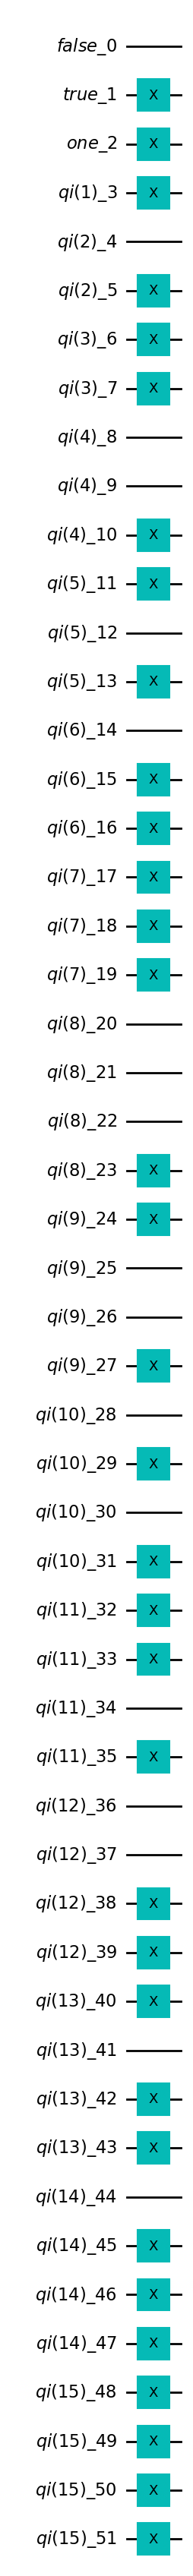

In [39]:
##
##  Small addition problem, can be emulated locally
##
qc = QC()
qi = QVarArith(qc)
for i in range(1,16):
    a = qi.qint(i)
qc.draw()
# ans = qi.add(a,b)
# m = qi.measure(ans)
# qc.em()

/Users/default/miniconda3/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


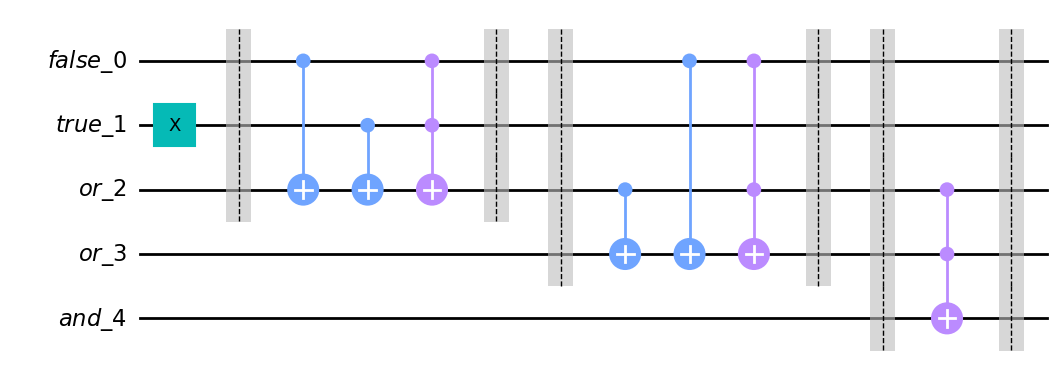

In [5]:
##
## Test the logic generation
##
qc = QC()
a = qc.qor(qc.falseBit, qc.trueBit)
b = qc.qor(a, qc.falseBit)
qc.qand(a,b)
qc.draw()

In [18]:
##
##  Small addition problem, can be emulated locally
##
qc = QC()
qi = QArith(qc,3)
a = qi.qint(2)
b = qi.qint(4)
ans = qi.add(a,b)
m = qi.measure(ans)
qc.em()

{'1 1 0': 512}

In [7]:
##
## Much larger, 32 bit problem
##
qc = QC()
qi = QArith(qc, 32)
ans = qi.qint(0)
for i in range(1,10):
    n = qi.qint(i)
    ans = qi.add(ans,n)
m = qi.measure(ans)
# qc.draw()

In [8]:
qc.bem(shots=16)

Job Status: job has successfully run


{'0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1': 16}

# Subset Sum

In [36]:
# qc = QC()
# s = [3,17,4,9,26,12] 
# target = 33
# x_vec = [1,0,0,1,1,0]
##
## maybe subset isn't the best name, it's just the set of integers
##   for the problem
##
class QSubsetSum:
    
    def __init__(self, qc, values, target):
        self.qc = qc
        self.values = values
        self.target = target
    
    def run(self):
        self.values.sort()
        self.width = int(np.log2(sum(self.values)))+1 #placeholder: width = log2(sum) -- code this
        #print(self.width)
        self.qi = QArith(self.qc, self.width)
        self.qv = QVarArith(self.qc)
        self.x = []
        for i in range(len(self.values)): #creates x register
            r = self.qc.addReg(prefix = "x")
            self.x.append(r)
            ##
            ##  go ahead and call for the superposition of all
            ##   possible x values
            ##
            self.qc.getQuantumCircuit().h(r)
        print(self.x)
        ##
        ##  Create the running sum of integers in my (unsorted) set
        ##  ans maintains the running sum, and is returned at thend
        ##  By "sum" we mean that each integer in the set is either added
        ##    into the sum, or not, depending on the x control register
        ##  
        ##  ans starts out as a new register, all 0
        ##
        ans = self.qi.qint(0, name = "sum")
        for i, s in enumerate(self.values): #stores integers as quantum registers
            r = self.qi.qint(s)
            ctrl = self.x[i]    
            shadow = self.qi.qint(0, name = "shd")
            print(len(shadow))
            for a in range(len(shadow)):
                self.qc.getQuantumCircuit().ccx(ctrl, r[a], shadow[a]) #
            ans = self.qi.add(ans, shadow)
            print("ans", ans)
        self.qi.measure(ans)    
        return ans
            #add up all shadow vals together, keep a running sum
        


In [37]:
qc = QC()
s = [2,7,4] #,9,26,12] 
#we want ans0 to be 2 bits (2), ans1 to be 3 bits (4+2), ans2 to be 4 bits(7+4+2)
target = 33
qsub = QSubsetSum(qc, s, target)
qsub.run()
#qc.draw('mpl')


4
[2, 4, 7]
[QuantumRegister(1, 'x_6'), QuantumRegister(1, 'x_7'), QuantumRegister(1, 'x_8')]
4
ans [QuantumRegister(1, 'xor3_21'), QuantumRegister(1, 'xor3_23'), QuantumRegister(1, 'xor3_25'), QuantumRegister(1, 'xor3_27')]
4
ans [QuantumRegister(1, 'xor3_37'), QuantumRegister(1, 'xor3_39'), QuantumRegister(1, 'xor3_41'), QuantumRegister(1, 'xor3_43')]
4
ans [QuantumRegister(1, 'xor3_53'), QuantumRegister(1, 'xor3_55'), QuantumRegister(1, 'xor3_57'), QuantumRegister(1, 'xor3_59')]


[QuantumRegister(1, 'xor3_53'),
 QuantumRegister(1, 'xor3_55'),
 QuantumRegister(1, 'xor3_57'),
 QuantumRegister(1, 'xor3_59')]

In [11]:
qc.bem()

Job Status: job has successfully run


{'1 1 0 1': 65,
 '1 0 1 1': 62,
 '0 1 1 0': 58,
 '0 1 0 0': 65,
 '0 0 1 0': 57,
 '0 0 0 0': 85,
 '0 1 1 1': 65,
 '1 0 0 1': 55}